Epoch 1/20
1000/1000 [==============================] - 2s 1ms/step - loss: 0.0025 - mae: 0.0278 - val_loss: 9.2505e-04 - val_mae: 0.0199
Epoch 2/20
1000/1000 [==============================] - 1s 1ms/step - loss: 6.8330e-04 - mae: 0.0164 - val_loss: 6.0095e-04 - val_mae: 0.0160
Epoch 3/20
1000/1000 [==============================] - 1s 1ms/step - loss: 4.8452e-04 - mae: 0.0139 - val_loss: 4.8843e-04 - val_mae: 0.0146
Epoch 4/20
1000/1000 [==============================] - 1s 1ms/step - loss: 3.4612e-04 - mae: 0.0117 - val_loss: 3.8868e-04 - val_mae: 0.0125
Epoch 5/20
1000/1000 [==============================] - 1s 1ms/step - loss: 2.7853e-04 - mae: 0.0100 - val_loss: 3.4620e-04 - val_mae: 0.0114
Epoch 6/20
1000/1000 [==============================] - 1s 1ms/step - loss: 2.5833e-04 - mae: 0.0094 - val_loss: 3.3253e-04 - val_mae: 0.0109
Epoch 7/20
1000/1000 [==============================] - 1s 1ms/step - loss: 2.4801e-04 - mae: 0.0092 - val_loss: 3.1976e-04 - val_mae: 0.0109
Epoch 8/20

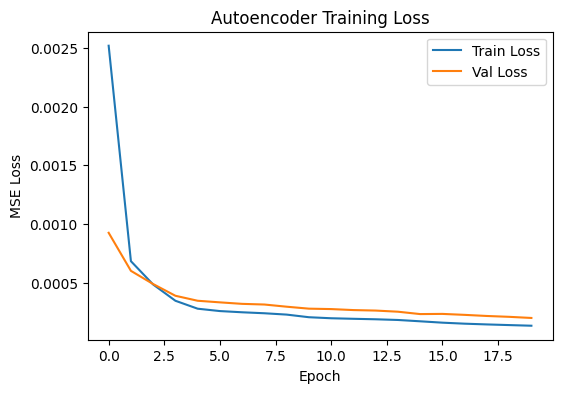

In [1]:
# ============================================================
# Autoencoder for Anomaly Detection (LP-IV Problem)
# ============================================================

# a. Import required libraries
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# b. Upload / access the dataset
# ------------------------------------------------------------
# Example: credit_card_data.csv should contain transaction features + Class column (0=normal, 1=fraud)

data = pd.read_csv("LP-IV-datasets/creditcardfraud-csv/creditcardfraud-csv/creditcard.csv")

# Separate features and labels
X = data.drop('Class', axis=1).values
y = data['Class'].values

# Normalize features
X = X.astype('float32')
X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0) + 1e-6)

# Split into training (only normal) and testing (normal + fraud)
X_train = X[y == 0]
X_test = X
y_test = y

# ------------------------------------------------------------
# c. Encoder: compress input to latent representation
# ------------------------------------------------------------
input_dim = X_train.shape[1]  # number of features

input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(64, activation='relu')(input_layer)
encoded = layers.Dense(32, activation='relu')(encoded)
encoded = layers.Dense(16, activation='relu')(encoded)

# ------------------------------------------------------------
# d. Decoder: reconstruct the input
# ------------------------------------------------------------
decoded = layers.Dense(32, activation='relu')(encoded)
decoded = layers.Dense(64, activation='relu')(decoded)
decoded = layers.Dense(input_dim, activation='sigmoid')(decoded)

# Combine Encoder + Decoder
autoencoder = models.Model(inputs=input_layer, outputs=decoded)

# ------------------------------------------------------------
# e. Compile the model with optimizer, loss, and metrics
# ------------------------------------------------------------
autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train Autoencoder only on normal (non-fraud) data
history = autoencoder.fit(
    X_train, X_train,
    epochs=20,
    batch_size=256,
    validation_split=0.1,
    shuffle=True,
    verbose=1
)

# ------------------------------------------------------------
# Evaluate reconstruction error on test set
# ------------------------------------------------------------
reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)

# Determine threshold for anomaly detection
threshold = np.percentile(mse, 95)
print(f"Reconstruction error threshold: {threshold:.6f}")

# Predict anomalies
y_pred = (mse > threshold).astype(int)

# ------------------------------------------------------------
# Performance summary
# ------------------------------------------------------------
from sklearn.metrics import classification_report, confusion_matrix

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# ------------------------------------------------------------
# Plot training loss
# ------------------------------------------------------------
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()
